In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [3]:
# For saving plots
import os

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [4]:
# Load preprocessed dataset (or raw if you want to preprocess here)
data = pd.read_csv('../data/stars.csv')

# Quick look
data.head()

,Temperature(K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3042,0.0005,0.1542,16.6,0.0,Red,M
2,2600,0.0003,0.102,18.7,0.0,Red,M
3,2800,0.0002,,16.65,0.0,Red,M
4,1939,0.000138,0.103,20.06,0.0,Red,M


In [5]:

#Fill missiong values

# Strip spaces from column names
data.columns = data.columns.str.strip()

#  Replace empty strings and whitespace-only cells with NaN
data = data.replace(r'^\s*$', pd.NA, regex=True)

# Convert numeric columns to proper numbers
numeric_cols = ['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing Luminosity and Radius using median per Star type
for col in ['Luminosity(L/Lo)', 'Radius(R/Ro)']:
    data[col] = data.groupby('Star type')[col].transform(lambda x: x.fillna(x.median()))

# Fill missing Temperature with overall median
data['Temperature(K)'] = data['Temperature(K)'].fillna(data['Temperature(K)'].median())

# Optional: Fill Absolute magnitude with median per Star type
data['Absolute magnitude(Mv)'] = data.groupby('Star type')['Absolute magnitude(Mv)'].transform(
    lambda x: x.fillna(x.median())
)

# Drop any rows where critical numeric columns are still missing
data = data.dropna(subset=['Temperature(K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)'])

# Check cleaned data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 1 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          239 non-null    float64
 1   Luminosity(L/Lo)        239 non-null    float64
 2   Radius(R/Ro)            239 non-null    float64
 3   Absolute magnitude(Mv)  239 non-null    float64
 4   Star type               239 non-null    float64
 5   Star color              233 non-null    object 
 6   Spectral Class          237 non-null    object 
dtypes: float64(5), object(2)
memory usage: 14.9+ KB
None
   Temperature(K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
1          3042.0          0.000500        0.1542                   16.60   
2          2600.0          0.000300        0.1020                   18.70   
3          2800.0          0.000200        0.1020                   16.65   
4          1939.0          0.000138        0.1030         

In [6]:
# Log-transform Luminosity
data['log_Luminosity'] = np.log10(data['Luminosity(L/Lo)'])

# Encode categorical features
data['Spectral Class'] = data['Spectral Class'].fillna('Unknown')
encoder = OneHotEncoder(drop='first', sparse_output=False)
spectral_encoded = encoder.fit_transform(data[['Spectral Class']])

# Use the correct input column name here
spectral_df = pd.DataFrame(spectral_encoded, columns=encoder.get_feature_names_out(['Spectral Class']))

# Concatenate encoded columns
data = pd.concat([data, spectral_df], axis=1)

# Features and target
features = ['Temperature(K)', 'Radius(R/Ro)', 'Star type'] + list(spectral_df.columns)
X = data[features]
y = data['log_Luminosity']

# Scale numerical features
scaler = StandardScaler()
X.loc[:, ['Temperature(K)', 'Radius(R/Ro)']] = scaler.fit_transform(X[['Temperature(K)', 'Radius(R/Ro)']])


In [7]:
### Exploratory Data Analyisis (EDA)

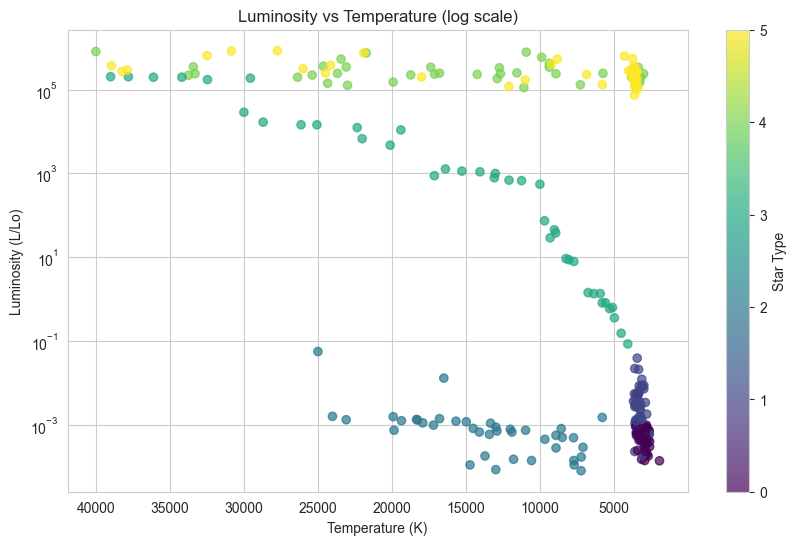

In [8]:
# Luminosity vs Temperature (log scale)
plt.scatter(data['Temperature(K)'], data['Luminosity(L/Lo)'], c=data['Star type'], cmap='viridis', alpha=0.7)
plt.yscale('log')
plt.xlabel("Temperature (K)")
plt.ylabel("Luminosity (L/Lo)")
plt.title("Luminosity vs Temperature (log scale)")
plt.gca().invert_xaxis()  # HR diagram style
plt.colorbar(label='Star Type')
plt.show()


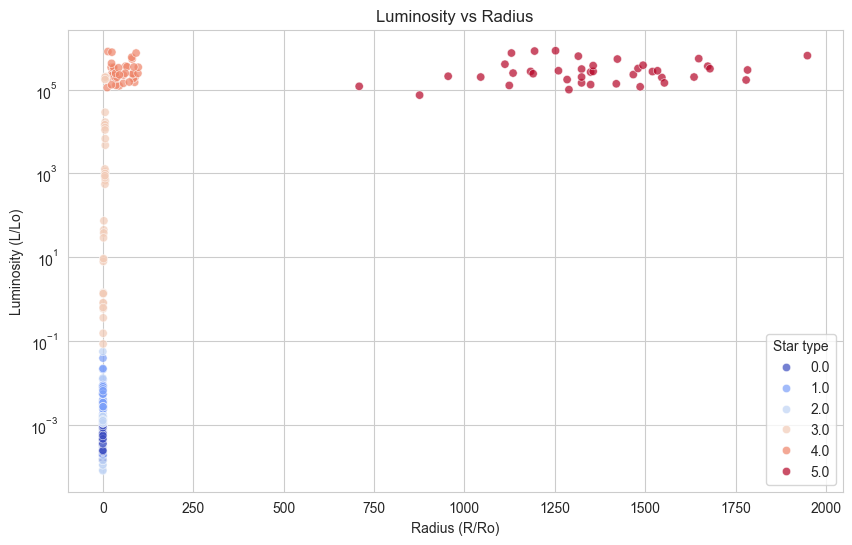

In [9]:
sns.scatterplot(x='Radius(R/Ro)', y='Luminosity(L/Lo)', hue='Star type', data=data, palette='coolwarm', alpha=0.7)
plt.yscale('log')
plt.xlabel("Radius (R/Ro)")
plt.ylabel("Luminosity (L/Lo)")
plt.title("Luminosity vs Radius")
plt.show()



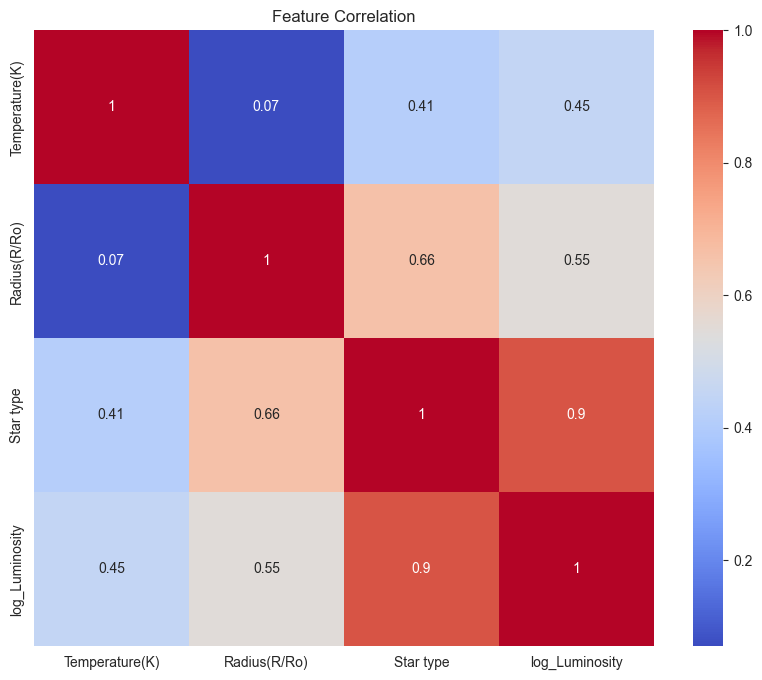

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(data[['Temperature(K)', 'Radius(R/Ro)', 'Star type', 'log_Luminosity']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


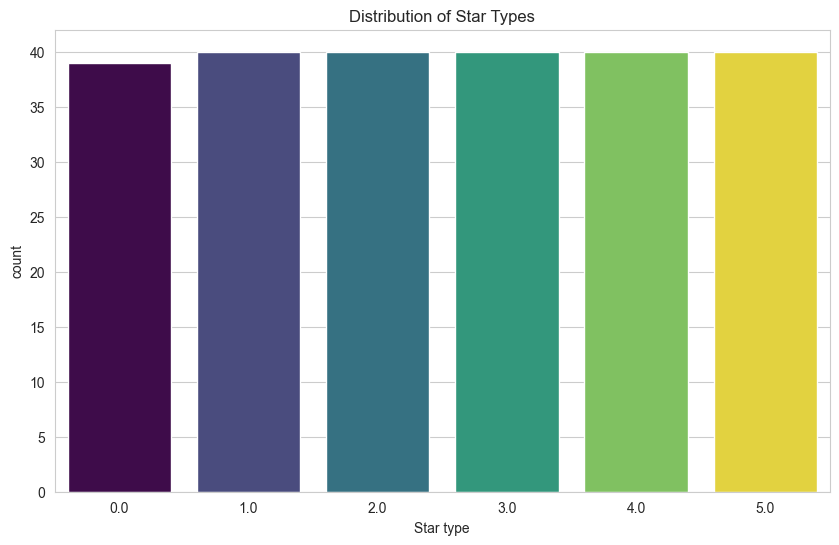

In [11]:
#Star Type Distribution

sns.countplot(x='Star type', hue='Star type', data=data, palette='viridis', dodge=False, legend=False)
plt.title("Distribution of Star Types")
plt.show()


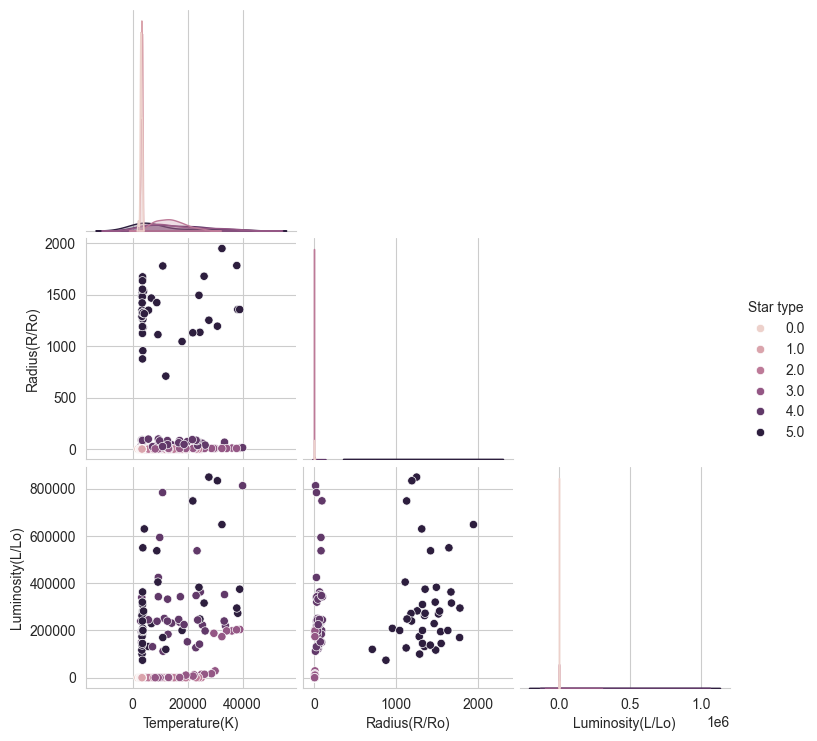

In [12]:
#Pairplot for numeric features
sns.pairplot(data[['Temperature(K)', 'Radius(R/Ro)', 'Luminosity(L/Lo)', 'Star type']], hue='Star type', corner=True)



In [13]:
### Split data into training data and test data


In [14]:
# Fill remaining numeric NaNs with median (catch-all)
X = X.fillna(X.median())
y = y.fillna(y.median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
### Linear Regression Model

In [16]:

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2: {r2:.6f}")
print(f"RMSE: {rmse:.6f}")


R^2: 0.863770
RMSE: 1.425779


In [17]:
### Predictions VS Actual

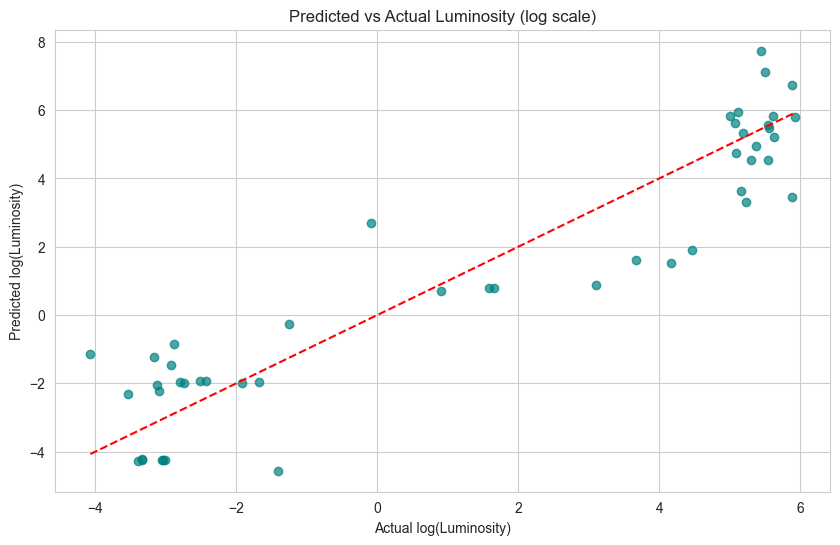

In [18]:
plt.scatter(y_test, y_pred, alpha=0.7, c='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual log(Luminosity)")
plt.ylabel("Predicted log(Luminosity)")
plt.title("Predicted vs Actual Luminosity (log scale)")
plt.show()


In [19]:
# Interaction terms & polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_train)
y_poly_pred = lr_poly.predict(X_poly_test)

r2_poly = r2_score(y_test, y_poly_pred)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_poly_pred))
print(f"Polynomial Regression R^2: {r2_poly:.4f}, RMSE: {rmse_poly:.4f}")


Polynomial Regression R^2: 0.2061, RMSE: 3.4420


In [20]:
# Create results directory if it doesn't exist
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'Star Type': data.loc[y_test.index, 'Star type'].values,
    'Actual Luminosity': 10 ** y_test.values,
    'Predicted Luminosity': 10 ** y_pred
})

# Save CSV inside results folder
file_path = os.path.join(results_dir, "predictions.csv")
predictions_df.to_csv(file_path, index=False)

print(f"Predictions saved successfully at: {file_path}")

Predictions saved successfully at: results\predictions.csv
